In [4]:
#| default_exp learner

In [5]:
import sys; sys.path.append('/notebooks')

In [6]:
#|export

import math
import torch
from torch import nn, tensor
import matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from tqdm.auto import trange, tqdm

from torch import optim
import torch.nn.functional as F

from miniai.conv import *
from fastprogress import progress_bar, master_bar

torch_device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(torch_device)

In [7]:
import matplotlib as mpl
import torchvision.transforms.functional as TF
from contextlib import contextmanager
from datasets import load_dataset, load_dataset_builder
from miniai.datasets import *
from miniai.conv import *
import logging
from fastcore.test import test_close
from IPython.core.debugger import set_trace
%load_ext tensorboard

In [8]:
torch.set_printoptions(precision=2, linewidth=120, sci_mode=False)
torch.manual_seed(42)
plt.style.use('fast')
logging.disable(logging.WARNING)

In [9]:
x, y = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]] 

In [11]:
bs = 512
tds = dsd.with_transform(transformi)

In [12]:
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([512, 784]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

# Learner

Let's start with a basic version

In [10]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
        
    def fit(self, n_epochs):
        self.accs, self.losses, self.ns = [], [], []
        self.model.to(device) 
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in trange(n_epochs):
            self.one_epoch(train=True)
            with torch.no_grad():
                self.one_epoch(train=False)
                
    def one_epoch(self, train=True):
        self.model.training = train
        dl = self.dls. train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl):
            self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)        
        
    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)    

In [13]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [12]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

  0%|          | 0/1 [00:00<?, ?it/s]

0 True 0.9668893229166666 0.66605
0 False 0.9255211495535715 0.6796142857142857


# Learner with callbacks

Let's make it customizable

In [14]:
#|export
class Learner: pass

class Callback: 
    order = 0
    
    def before_fit(self, learn: Learner): pass
    def after_fit(self, learn: Learner): pass
    def before_epoch(self, learn: Learner): pass
    def after_epoch(self, learn: Learner): pass
    def before_batch(self, learn: Learner): pass
    def after_batch(self, learn: Learner): pass

In [15]:
#|export
def run_cbs(cbs, method_name, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_name, None)
        if method is not None: method(learn)

In [16]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [17]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1    
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [18]:
cbs = [CompletionCB()]

In [19]:
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 2 batches


In [20]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in tqdm(self.epochs):
                self.one_epoch(train=True)
                self.one_epoch(train=False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def one_epoch(self, train=False):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def one_batch(self):
        self.xb, self.yb = self.batch
        self.preds = self.model(self.xb) 
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def callback(self, method_name): 
        run_cbs(self.cbs, method_name, self)

In [21]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [22]:
learner = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learner.fit(1)

  0%|          | 0/1 [00:00<?, ?it/s]

Completed 128 batches


In [23]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
        
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    def calc(self, inps, targs): return inps

In [24]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps == targs).float().mean()

In [25]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [26]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32 + 0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

### torcheval metrics

It turns out pytorch already has plenty metrics implemented in the package `torcheval`

In [27]:
#!pip install torcheval

In [28]:
#|export
from torcheval.metrics import MulticlassAccuracy, Mean

In [29]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [30]:
metric.reset()
metric.compute()

tensor(nan)

# Let's do some callbacks

In [31]:
#| export
def to_cpu(x):
    if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [46]:
#|export
class M(dict):
    def __init__(self, d, epoch, train=True): 
        super().__init__(d)
        self.train = train
        self.epoch = epoch

class Recorder(list):
    def __init__(self, *items): super().__init__(items)
    def add(self, d, epoch, train): self.append(M(d, epoch, train))
    def get_latest(self):
        latest = dict(self[-1].items())
        latest['epoch'] = self[-1].epoch
        latest['train'] = self[-1].train   
        return latest

    def log_latest(self): print(self.get_latest())
        
    
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.recorder = Recorder()
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        
    def before_fit(self, learn): 
        learn.metrics = self
        learn.recorder = self.recorder
        
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    
    def after_epoch(self, learn):
        train = 'train' if learn.model.training else 'valid'
        self.recorder.add({k: v.compute().item() for k, v in self.all_metrics.items()}, 
                          learn.epoch, train)
        self._log(self.recorder)
    
    def _log(self, recorder): recorder.log_latest()
    
    def after_batch(self, learn):
        with torch.no_grad():
            x, y, *_ = to_cpu(learn.batch)
            for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
            self.loss.update(to_cpu(learn.loss), weight=len(x))

In [47]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=device): self.device = device
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [48]:
model = get_model()
metrics = MetricsCB(MulticlassAccuracy())

In [49]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'MulticlassAccuracy': 0.6817499995231628, 'loss': 0.9279785505930582, 'epoch': 0, 'train': 'train'}
{'MulticlassAccuracy': 0.775600016117096, 'loss': 0.633462191772461, 'epoch': 0, 'train': 'valid'}


# Even more flexible Learner

In [50]:
#| export
from IPython.core.debugger import set_trace
class with_cbs:
    def __init__(self, name): self.name = name
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o._callback(f'before_{self.name}')
                f(o, *args, **kwargs)
                o._callback(f'after_{self.name}')
            except globals()[f'Cancel{self.name.title()}Exception']: pass
            finally: o._callback(f'cleanup_{self.name}')
        return _f

class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        self.model = model
        self.dls = dls
        self.loss_func=loss_func
        self.lr=lr
        self.cbs = fc.L(cbs)
        self.opt_func = opt_func

    def fit(self, n_epochs=1, train=True, valid=True, lr=None, cbs=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb) # add extra cbs
        try:
            self.n_epochs = n_epochs            
            self.epochs = range(n_epochs)
            self.model.train(train) # Set model training before any callbacks are called
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb) # cleanup extra cbs

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: 
                self.one_epoch(True)
            if valid:
                with torch.no_grad():
                    self.one_epoch(False)
   
    def one_epoch(self, train):
        self.model.train(train) 
        self.dl = self.dls.train if train else self.dls.valid  
        self.dl_len = len(self.dl)
        self._one_epoch(train)

    @with_cbs('epoch')
    def _one_epoch(self, train):
        for self.iter, self.batch in enumerate(self.dl):
            self.one_batch()
            
    @with_cbs('batch')    
    def one_batch(self):
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()  

    # these are defined here to allow subclassing to customize behavior
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): 
        self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

    def _callback(self, method_name): run_cbs(self.cbs, method_name, self)
    
    @property
    def training(self):
        return self.model.training

In [51]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': 0.6798666715621948, 'loss': 0.9412253568013509, 'epoch': 0, 'train': 'train'}
{'accuracy': 0.6966000199317932, 'loss': 0.9872826904296875, 'epoch': 0, 'train': 'valid'}


In [60]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        self.first = True
        learn.epochs = self.mbar = master_bar(learn.epochs)
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        
    def _format_metric(self, m):
        if isinstance(m, float): return f'{m:.3f}'
        return m
        
    def _log(self, recorder):
        d = recorder.get_latest()
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first=False
        self.mbar.write(list(self._format_metric(x) for x in d.values()), table=True)
        
    def before_epoch(self, learn): 
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.3f}"
        if self.plot and hasattr(learn, 'metrics') and learn.model.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

accuracy,loss,epoch,train
0.677,0.961,0,train
0.746,0.686,0,valid
0.790,0.597,1,train
0.761,0.634,1,valid
0.815,0.528,2,train
0.818,0.506,2,valid


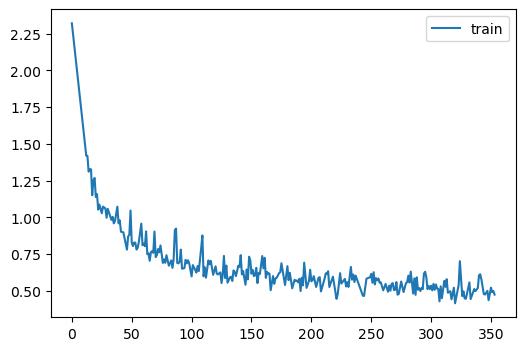

In [61]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

In [62]:
#|export 
from torch.utils.tensorboard import SummaryWriter

class TensorboardCB(Callback):
    order = MetricsCB.order + 1    
    def __init__(self, name=None): self.writer = SummaryWriter(comment=f'_{name}')

    def after_batch(self, learner: Learner):        
        # Log loss
        train = 'train' if learn.model.training else 'valid'
        idx = learn.dl_len*learn.epoch + learn.iter
        self.writer.add_scalar(f'loss/{train}', learn.loss.item(), idx)     
        self.writer.flush()

    def after_epoch(self, learn: Learner):
        if hasattr(learn, 'recorder'):
            # Log all other metrics after each epoch
            d = learn.recorder[-1]
            for k, v in d.items():
                if k == 'loss': continue
                self.writer.add_scalar(f'{k}/{d.train}', v, d.epoch)    
            self.writer.flush()
            
    def after_fit(self, learner: Learner): self.writer.close()

In [63]:
#|export
import wandb

class Config(dict):
    def __init__(self, ds, arch, **kwargs):
        opts = { 'epochs': 5, 'lr': 1e-4 }
        opts.update(kwargs)
        super().__init__(ds=ds, arch=arch, **opts)

    def __getattr__(self, key):
        if key in self:
            return self[key]
        return super().__getattr__(self, key)

class WandBCB(Callback):
    order = MetricsCB.order + 1
    def __init__(self, config: Config, project='fastai2022p2'): 
        self.project = project
        self.config = config
        
    def before_fit(self, learner: Learner): wandb.init(project=self.project, config=self.config)        
    def after_fit(self, learner: Learner): wandb.finish()        

    def after_batch(self, learner: Learner):
        # Log loss
        train = 'train' if learn.model.training else 'valid'
        wandb.log({f'{train}/loss': learn.loss.item()})
    
    def after_epoch(self, learner: Learner):
        if not hasattr(learn, 'recorder'): return # skip if we don't have metrics to log
        # Log all metrics
        latest = learn.recorder[-1]
        wandb.log({f'{latest.train}/{k}': v for k, v in latest.items()})    


In [64]:
class LogEpochCB(Callback):
    def before_epoch(self, learn): print(f'Epoch {learn.epoch}/{learn.n_epochs}')

class FailCB(Callback):
    def before_epoch(self, learn): 
        if learn.epoch == 1:
            print(f"Cancelling at epoch {learn.epoch}")
            raise CancelFitException("oops")

In [65]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[LogEpochCB(), FailCB()])
learn.fit(3)

Epoch 0/3
Epoch 0/3
Epoch 1/3
Cancelling at epoch 1


## Momentum Learner

In [66]:
#|export
class MomentumLearner(Learner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                # Instead of zeroing out the gradients, we just keep a residue
                p.grad *= self.mom 

accuracy,loss
0.729,0.792
0.748,0.650
0.827,0.495
0.823,0.502
0.841,0.455
0.834,0.464
0.853,0.417
0.841,0.448
0.858,0.402
0.846,0.436


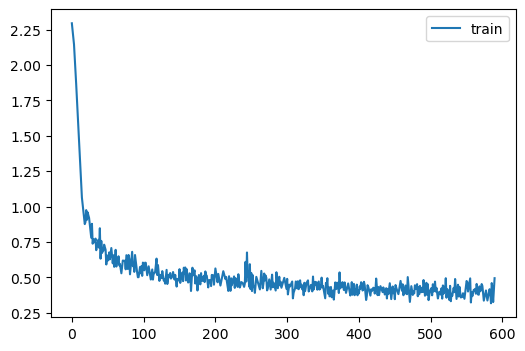

train/accuracy,▁▆▇██
train/loss,█▄▃▃▂▃▂▂▃▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▂▁
valid/accuracy,▁▆▇██
valid/loss,▇▆▇▇█▇▆▇▃▃▄▃▄▃▃▃▂▂▃▂▄▂▂▂▁▂▃▂▃▁▂▂▂▁▃▂▃▁▂▂
train/accuracy,0.85803
train/loss,0.40215
valid/accuracy,0.8456
valid/loss,0.43645


In [50]:
config = Config(arch='fully connected', ds='fashion_mnist', lr=1e-1, mom=0.75)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, WandBCB(project='fastai', config=config), ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=config.lr, cbs=cbs, mom=config.mom)
learn.fit(config.epochs)

accuracy,loss
0.636,1.110
0.658,0.850
0.757,0.685
0.720,0.732
0.796,0.590
0.794,0.590
0.811,0.545
0.802,0.555
0.821,0.513
0.787,0.598


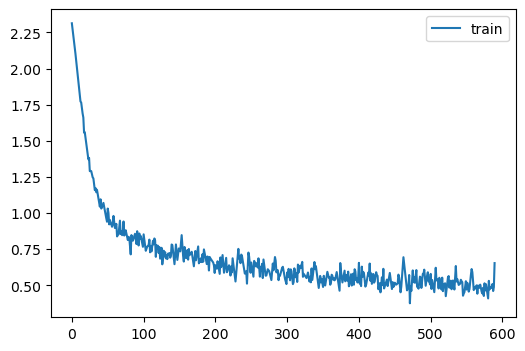

In [120]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(5)

## LRFinderCB

In [133]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf
        
    def after_batch(self, learn):
        if not learn.model.training: raise CancelEpochException() # Only find LR during training
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
        

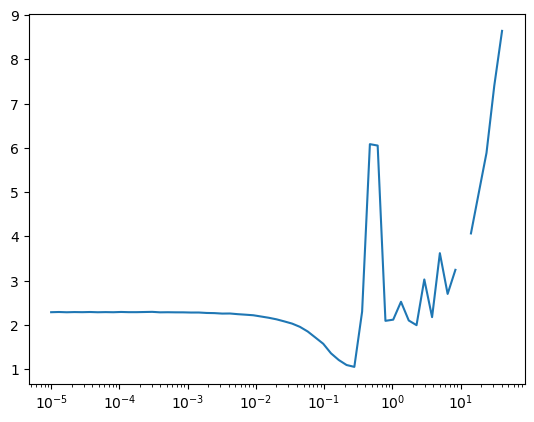

In [134]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [135]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3, verbose=False): fc.store_attr()
    
    def before_fit(self, learn):
        self.scheduler = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf
        
    def after_batch(self, learn):        
        if not learn.model.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if self.verbose:
            print(f"lr={learn.opt.param_groups[0]['lr']:.2f}\tloss={loss:.2f}\tmin_loss={self.min:.2f}")

        if loss < self.min: self.min = loss
        if math.isnan(loss) or loss > self.max_mult*self.min: 
            raise CancelFitException()
        self.scheduler.step()
        
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [140]:
#|export
@fc.patch
def lr_find(self: Learner, start_lr=1e-5, gamma=1.3, max_mult=3, max_epochs=10, verbose=False):
    self.fit(n_epochs=max_epochs, lr=start_lr, cbs=[DeviceCB(), LRFinderCB(gamma=gamma, max_mult=max_mult, verbose=verbose)])

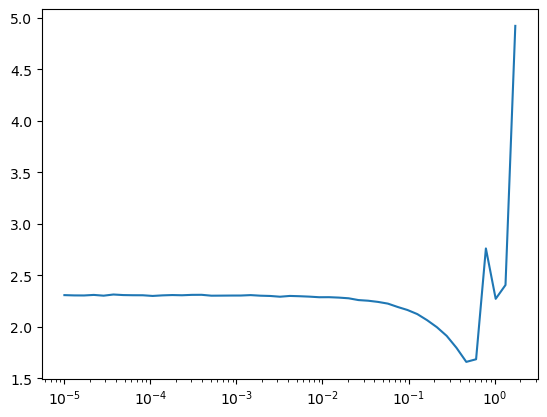

In [143]:
torch.manual_seed(10041987)
learn = Learner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB(), ProgressCB(plot=True)]).lr_find()

In [ ]:
#|export
class SingleBatchCB(Callback):
    order = 1
    def __init__(self, verbose=False): self.verbose = verbose
    def after_batch(self, learn: Learner):
        if self.verbose: print(f"Stopping at epoch {learn.epoch_idx}")
        raise CancelFitException

In [67]:
import nbdev; nbdev.nbdev_export();